In [1]:
import random
import shutil
import matplotlib.pyplot as plt
import os
from google.colab import drive, files
from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img
from tqdm import tqdm
from collections import Counter

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"muhammadtsaqiifa","key":"1572ef8a163b81d1b96bbe808a6d053f"}'}

In [4]:
!rm -rf skin_dataset/
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d pacificrm/skindiseasedataset
!unzip skindiseasedataset.zip -d skin_dataset

Streaming output truncated to the last 5000 lines.
  inflating: skin_dataset/SkinDisease/SkinDisease/train/Sun_Sunlight_Damage/phototoxic-reactions-lime-juice-2.jpeg  
  inflating: skin_dataset/SkinDisease/SkinDisease/train/Sun_Sunlight_Damage/phototoxic-reactions-lime-juice-3.jpeg  
  inflating: skin_dataset/SkinDisease/SkinDisease/train/Sun_Sunlight_Damage/sun-damaged-skin-1.jpeg  
  inflating: skin_dataset/SkinDisease/SkinDisease/train/Sun_Sunlight_Damage/sun-damaged-skin-10.jpeg  
  inflating: skin_dataset/SkinDisease/SkinDisease/train/Sun_Sunlight_Damage/sun-damaged-skin-100.jpeg  
  inflating: skin_dataset/SkinDisease/SkinDisease/train/Sun_Sunlight_Damage/sun-damaged-skin-101.jpeg  
  inflating: skin_dataset/SkinDisease/SkinDisease/train/Sun_Sunlight_Damage/sun-damaged-skin-102.jpeg  
  inflating: skin_dataset/SkinDisease/SkinDisease/train/Sun_Sunlight_Damage/sun-damaged-skin-103.jpeg  
  inflating: skin_dataset/SkinDisease/SkinDisease/train/Sun_Sunlight_Damage/sun-damaged-skin-1

In [6]:
# Path awal
train_dir = Path("/content/skin_dataset/SkinDisease/SkinDisease/train")
test_dir = Path("/content/skin_dataset/SkinDisease/SkinDisease/test")
combined_dir = Path("/content/all_data")
combined_dir.mkdir(parents=True, exist_ok=True)

# Gabungkan train dan test ke all_data/
for source_dir in [train_dir, test_dir]:
    for class_dir in source_dir.iterdir():
        if class_dir.is_dir():
            target_class_dir = combined_dir / class_dir.name
            target_class_dir.mkdir(parents=True, exist_ok=True)

            for img_path in class_dir.glob("*.*"):
                shutil.copy(img_path, target_class_dir / img_path.name)

# Hapus folder Unknown_Normal jika ada
unknown_normal_dir = combined_dir / "Unknown_Normal"
if unknown_normal_dir.exists() and unknown_normal_dir.is_dir():
    shutil.rmtree(unknown_normal_dir)
    print(f"Folder '{unknown_normal_dir}' berhasil dihapus.")
else:
    print(f"Folder '{unknown_normal_dir}' tidak ditemukan atau bukan direktori.")

Folder '/content/all_data/Unknown_Normal' berhasil dihapus.


In [7]:
# Path ke folder gabungan
combined_dir = "/content/all_data"

# Hitung jumlah gambar per kelas
class_counts = {}
for class_name in os.listdir(combined_dir):
    class_path = os.path.join(combined_dir, class_name)
    if os.path.isdir(class_path):
        num_images = len(os.listdir(class_path))
        class_counts[class_name] = num_images

# Urutkan berdasarkan jumlah
class_counts = dict(sorted(class_counts.items(), key=lambda x: x[1], reverse=True))

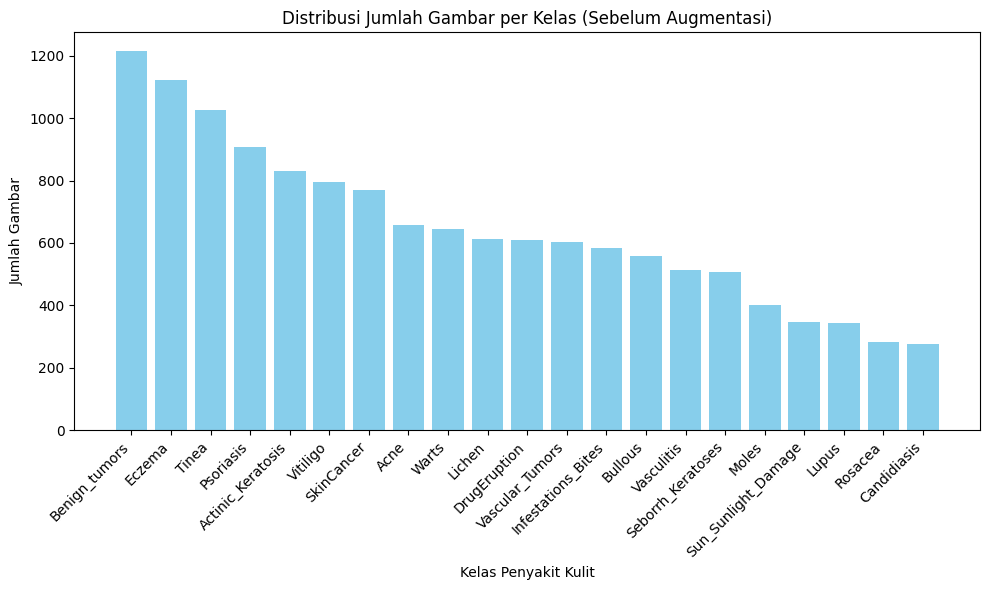

In [8]:
# Plot
plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.ylabel("Jumlah Gambar")
plt.xlabel("Kelas Penyakit Kulit")
plt.title("Distribusi Jumlah Gambar per Kelas (Sebelum Augmentasi)")
plt.tight_layout()
plt.show()

In [9]:
# Hitung jumlah gambar per kelas
class_counts = {
    cls: len([
        img for img in os.listdir(os.path.join(combined_dir, cls))
        if not img.startswith("aug")
    ])
    for cls in os.listdir(combined_dir)
    if os.path.isdir(os.path.join(combined_dir, cls))
}

# Cari jumlah maksimum (dijadikan target jumlah per kelas)
target_count = class_counts.get("Benign_Tumors", max(class_counts.values()))

print(f"Target jumlah gambar per kelas (Benign_Tumors): {target_count}")

Target jumlah gambar per kelas (Benign_Tumors): 1214


In [10]:
# Data augmentasi
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.05,
    height_shift_range=0.05,
    fill_mode="nearest"
)

for class_name, original_count in class_counts.items():
    class_path = os.path.join(combined_dir, class_name)
    images = [img for img in os.listdir(class_path) if not img.startswith("aug")]

    gap = target_count - original_count
    if gap <= 0:
        print(f"✅ {class_name} sudah cukup: {original_count} gambar.")
        continue

    # Berapa augmentasi per gambar asli
    augmentations_per_image = gap // len(images) + 1
    print(f"🔁 Augmentasi {class_name}: butuh +{gap} → ~{augmentations_per_image}x per gambar")

    total_augmented = 0
    for img_name in tqdm(images, desc=f"Augmenting {class_name}"):
        if total_augmented >= gap:
            break

        img_path = os.path.join(class_path, img_name)
        try:
            img = load_img(img_path)
            x = img_to_array(img).reshape((1,) + img_to_array(img).shape)

            aug_count = 0
            for batch in datagen.flow(
                x,
                batch_size=1,
                save_to_dir=class_path,
                save_prefix='aug',
                save_format='jpg'
            ):
                aug_count += 1
                total_augmented += 1
                if aug_count >= augmentations_per_image or total_augmented >= gap:
                    break

        except Exception as e:
            print(f"❌ Gagal augmentasi {img_path}: {e}")

print("✅ Augmentasi selesai. Semua kelas kini setara jumlahnya.")

🔁 Augmentasi Acne: butuh +556 → ~1x per gambar


Augmenting Acne:  84%|████████▍ | 556/658 [00:40<00:07, 13.77it/s]


🔁 Augmentasi Lupus: butuh +869 → ~3x per gambar


Augmenting Lupus:  84%|████████▍ | 290/345 [00:57<00:10,  5.00it/s]


🔁 Augmentasi Lichen: butuh +600 → ~1x per gambar


Augmenting Lichen:  98%|█████████▊| 600/614 [00:53<00:01, 11.31it/s]


🔁 Augmentasi Infestations_Bites: butuh +630 → ~2x per gambar


Augmenting Infestations_Bites:  54%|█████▍    | 315/584 [00:57<00:48,  5.51it/s]


🔁 Augmentasi Psoriasis: butuh +306 → ~1x per gambar


Augmenting Psoriasis:  34%|███▎      | 306/908 [00:31<01:02,  9.64it/s]


🔁 Augmentasi Tinea: butuh +189 → ~1x per gambar


Augmenting Tinea:  18%|█▊        | 189/1025 [00:20<01:28,  9.44it/s]


🔁 Augmentasi Vasculitis: butuh +701 → ~2x per gambar


Augmenting Vasculitis:  68%|██████▊   | 351/513 [01:13<00:33,  4.78it/s]


🔁 Augmentasi Warts: butuh +570 → ~1x per gambar


Augmenting Warts:  89%|████████▊ | 570/644 [01:01<00:07,  9.26it/s]


🔁 Augmentasi Rosacea: butuh +932 → ~4x per gambar


Augmenting Rosacea:  83%|████████▎ | 233/282 [01:16<00:16,  3.04it/s]


🔁 Augmentasi SkinCancer: butuh +444 → ~1x per gambar


Augmenting SkinCancer:  58%|█████▊    | 444/770 [00:47<00:35,  9.28it/s]


🔁 Augmentasi Vitiligo: butuh +418 → ~1x per gambar


Augmenting Vitiligo:  53%|█████▎    | 418/796 [00:20<00:18, 20.20it/s]


🔁 Augmentasi Sun_Sunlight_Damage: butuh +868 → ~3x per gambar


Augmenting Sun_Sunlight_Damage:  84%|████████▍ | 290/346 [01:32<00:17,  3.14it/s]


🔁 Augmentasi Candidiasis: butuh +939 → ~4x per gambar


Augmenting Candidiasis:  85%|████████▌ | 235/275 [01:32<00:15,  2.54it/s]


🔁 Augmentasi Seborrh_Keratoses: butuh +708 → ~2x per gambar


Augmenting Seborrh_Keratoses:  70%|██████▉   | 354/506 [01:05<00:28,  5.42it/s]


🔁 Augmentasi Eczema: butuh +92 → ~1x per gambar


Augmenting Eczema:   8%|▊         | 92/1122 [00:09<01:49,  9.39it/s]


✅ Benign_tumors sudah cukup: 1214 gambar.
🔁 Augmentasi Moles: butuh +813 → ~3x per gambar


Augmenting Moles:  68%|██████▊   | 271/401 [01:18<00:37,  3.47it/s]


🔁 Augmentasi Bullous: butuh +655 → ~2x per gambar


Augmenting Bullous:  59%|█████▊    | 328/559 [00:50<00:35,  6.50it/s]


🔁 Augmentasi Actinic_Keratosis: butuh +383 → ~1x per gambar


Augmenting Actinic_Keratosis:  46%|████▌     | 383/831 [00:25<00:29, 15.01it/s]


🔁 Augmentasi Vascular_Tumors: butuh +611 → ~2x per gambar


Augmenting Vascular_Tumors:  51%|█████     | 306/603 [01:05<01:03,  4.65it/s]


🔁 Augmentasi DrugEruption: butuh +606 → ~1x per gambar


Augmenting DrugEruption: 100%|█████████▉| 606/608 [00:50<00:00, 11.99it/s]

✅ Augmentasi selesai. Semua kelas kini setara jumlahnya.


In [11]:
# Hitung jumlah gambar per kelas
class_counts = {}
for class_name in os.listdir(combined_dir):
    class_path = os.path.join(combined_dir, class_name)
    if os.path.isdir(class_path):
        num_images = len(os.listdir(class_path))
        class_counts[class_name] = num_images

# Urutkan berdasarkan jumlah
class_counts = dict(sorted(class_counts.items(), key=lambda x: x[1], reverse=True))

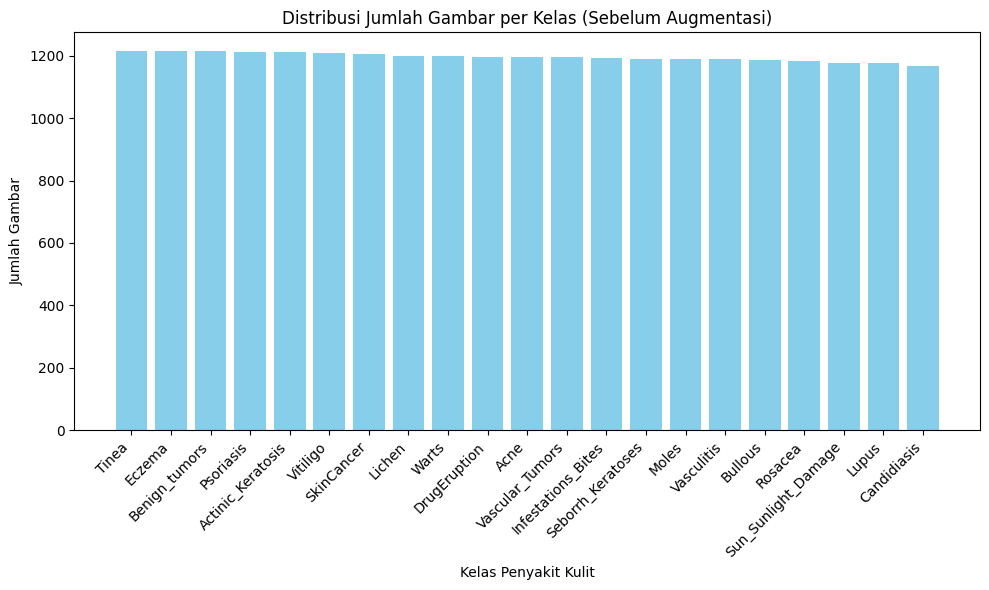

In [12]:
# Plot
plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.ylabel("Jumlah Gambar")
plt.xlabel("Kelas Penyakit Kulit")
plt.title("Distribusi Jumlah Gambar per Kelas (Sebelum Augmentasi)")
plt.tight_layout()
plt.show()

In [13]:
# Lokasi direktori dataset hasil augmentasi
dataset_dir = '/content/all_data'
zip_filename = '/content/skin_disease_augmented.zip'
drive_target = '/content/drive/MyDrive/skin_disease_augmented.zip'

# Kompres ke ZIP
shutil.make_archive(zip_filename.replace('.zip', ''), 'zip', dataset_dir)

print("✅ Dataset berhasil dikompres!")

✅ Dataset berhasil dikompres!


In [14]:
# Path tujuan di Google Drive
drive_target = '/content/drive/MyDrive/combined_dataset_augmented_V3.zip'

# Salin zip ke Google Drive
shutil.copy(zip_filename, drive_target)

print(f"✅ ZIP dataset berhasil disalin ke Google Drive: {drive_target}")

✅ ZIP dataset berhasil disalin ke Google Drive: /content/drive/MyDrive/combined_dataset_augmented_V3.zip


In [15]:
# !pip install -q imgaug

In [16]:
# import imageio
# from imgaug import augmenters as iaa

# augmented_dir = Path("/content/augmented_all_data")
# augmented_dir.mkdir(parents=True, exist_ok=True)

# augmentor = iaa.Sequential([
#     iaa.Fliplr(0.5),
#     iaa.Affine(rotate=(-20, 20)),
#     iaa.GaussianBlur(sigma=(0, 1.0)),
#     iaa.AdditiveGaussianNoise(scale=(3, 12))
# ])

# for class_dir in combined_dir.iterdir():
#     if class_dir.is_dir():
#         target_class_dir = augmented_dir / class_dir.name
#         target_class_dir.mkdir(parents=True, exist_ok=True)

#         for img_path in class_dir.glob("*.*"):
#             try:
#                 img = imageio.imread(img_path)
#                 # Simpan original
#                 imageio.imwrite(target_class_dir / img_path.name, img)

#                 # Augmentasi 3x
#                 for i in range(3):
#                     aug_img = augmentor(image=img)
#                     aug_name = f"{img_path.stem}_aug{i}.jpg"
#                     imageio.imwrite(target_class_dir / aug_name, aug_img)
#             except:
#                 print(f"Failed to process {img_path}")

In [17]:
# !zip -r /content/drive/MyDrive/augmented_skin_dataset_combined.zip /content/augmented_all_data